<a href="https://colab.research.google.com/github/01PrathamS/crop_classification/blob/main/baj_cas_cot_tf_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from keras.models import Model
from keras.layers import *
from keras import backend as K
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [79]:
train_dir = '/content/drive/MyDrive/bajra_castor_cotton_data/train'  ## for bajra 250 images and other 2 classes have 420 images
validation_dir = '/content/drive/MyDrive/bajra_castor_cotton_test_images_50(3)' ## nearly 50 images per class
test_dir = '/content/drive/MyDrive/bajra_castor_cotton_test_images_33' ## nearly 33 images per class

In [80]:
BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            label_mode='categorical',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 label_mode='categorical',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           label_mode='categorical',
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 1123 files belonging to 3 classes.
Found 153 files belonging to 3 classes.
Found 30 files belonging to 3 classes.


In [81]:
train_dataset.class_names

['bajra', 'castor', 'cotton']

In [82]:
# class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [83]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [84]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


In [85]:
num_classes = len(np.unique(class_names))\

input_shape = (160,160,3)

base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

image_batch, label_batch = next(iter(train_dataset))
# label_batch = next(iter(train_labels))
feature_batch = base_model(image_batch)


base_model.trainable = True

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)

inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [86]:
len(model.trainable_variables)

158

In [87]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [88]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

"""
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)
"""




Epoch 1/10
36/36 [==============================] - 105s 2s/step - loss: 0.5392 - categorical_accuracy: 0.7801 - val_loss: 0.7285 - val_categorical_accuracy: 0.7647
Epoch 2/10
36/36 [==============================] - 88s 2s/step - loss: 0.2244 - categorical_accuracy: 0.9216 - val_loss: 0.3485 - val_categorical_accuracy: 0.8693
Epoch 3/10
36/36 [==============================] - 87s 2s/step - loss: 0.1167 - categorical_accuracy: 0.9573 - val_loss: 0.0772 - val_categorical_accuracy: 0.9739
Epoch 4/10
36/36 [==============================] - 85s 2s/step - loss: 0.1058 - categorical_accuracy: 0.9599 - val_loss: 0.0600 - val_categorical_accuracy: 0.9804
Epoch 5/10
36/36 [==============================] - 84s 2s/step - loss: 0.1857 - categorical_accuracy: 0.9341 - val_loss: 0.0690 - val_categorical_accuracy: 0.9869
Epoch 6/10
36/36 [==============================] - 107s 3s/step - loss: 0.0632 - categorical_accuracy: 0.9715 - val_loss: 0.0716 - val_categorical_accuracy: 0.9608
Epoch 7/10
36/

In [93]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

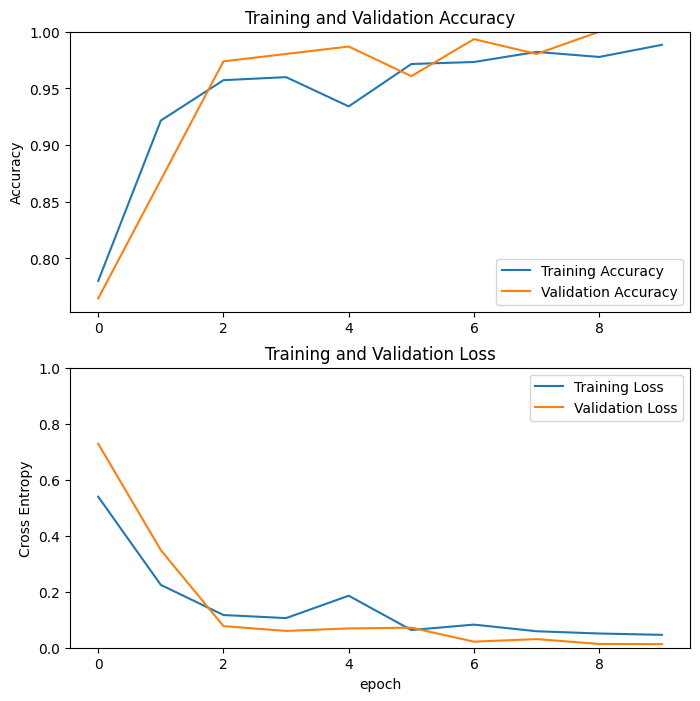

In [94]:
acc = history.history['categorical_accuracy']  # Use 'categorical_accuracy' for accuracy
val_acc = history.history['val_categorical_accuracy']  # Use 'val_categorical_accuracy' for validation accuracy

loss = history.history['loss']  # Use 'loss' for loss
val_loss = history.history['val_loss']  # Use 'val_loss' for validation loss

# The rest of your plotting code remains the same
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [95]:
model.evaluate(test_dataset)

1/1 [==============================] - 1s 640ms/step - loss: 0.0021 - categorical_accuracy: 1.0000


[0.002052632160484791, 1.0]

# Fine Tuning

In [96]:
base_model.trainable = True

print("Number of layeres in the base model: ",len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable=False

Number of layeres in the base model:  154


In [97]:

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')])


In [98]:
print(len(model.trainable_variables))

model.summary()

56
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                        

In [99]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
36/36 [==============================] - 54s 1s/step - loss: 0.0101 - accuracy: 0.9964 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 11/20
36/36 [==============================] - 45s 1s/step - loss: 0.0093 - accuracy: 0.9955 - val_loss: 0.0145 - val_accuracy: 0.9869
Epoch 12/20
36/36 [==============================] - 43s 1s/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 0.0037 - val_accuracy: 1.0000
Epoch 13/20
36/36 [==============================] - 44s 1s/step - loss: 0.0083 - accuracy: 0.9964 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 14/20
36/36 [==============================] - 44s 1s/step - loss: 0.0053 - accuracy: 0.9973 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 15/20
36/36 [==============================] - 43s 1s/step - loss: 0.0055 - accuracy: 0.9982 - val_loss: 0.0118 - val_accuracy: 0.9935
Epoch 16/20
36/36 [==============================] - 46s 1s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0132 - val_accuracy: 0.9935
Epoch 17/20
3

In [100]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

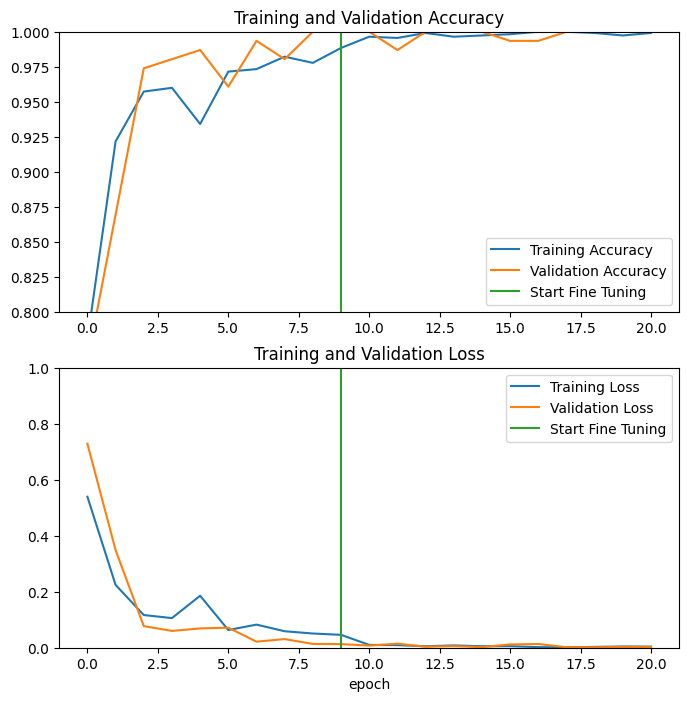

In [101]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 169ms/step
[[ 0.5541531  -0.16189086 -0.2847023 ]]


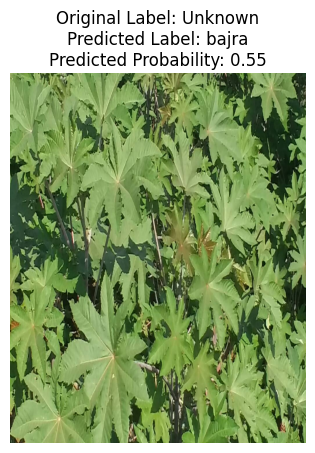

1/1 [==============================] - 0s 61ms/step
[[ 0.60770065 -0.18577288 -0.3208925 ]]


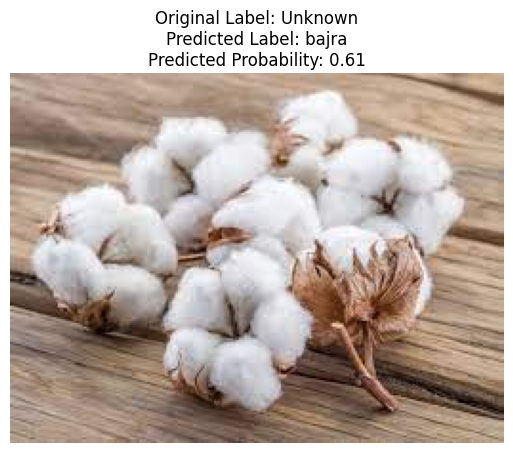

1/1 [==============================] - 0s 66ms/step
[[ 0.55365264 -0.18155995 -0.2948734 ]]


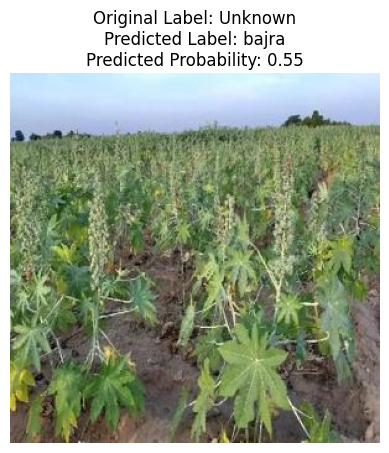

1/1 [==============================] - 0s 95ms/step
[[ 0.60760564 -0.15153402 -0.36509496]]


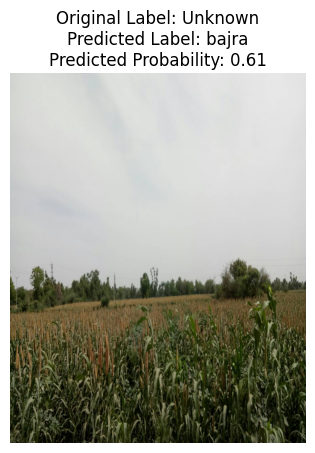

1/1 [==============================] - 0s 82ms/step
[[ 0.6387724  -0.23085989 -0.2895608 ]]


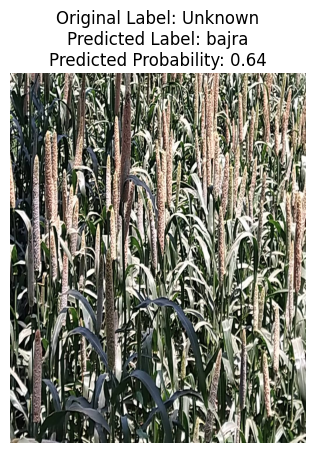

1/1 [==============================] - 0s 130ms/step
[[ 0.53709006 -0.17029816 -0.28222582]]


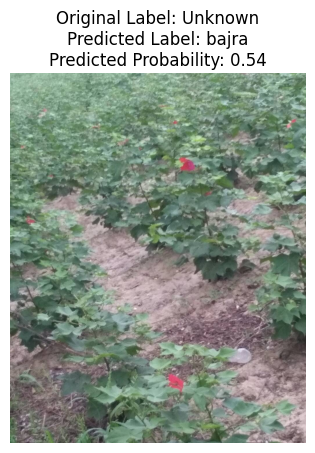

1/1 [==============================] - 0s 243ms/step
[[ 0.51459455 -0.16521567 -0.23578602]]


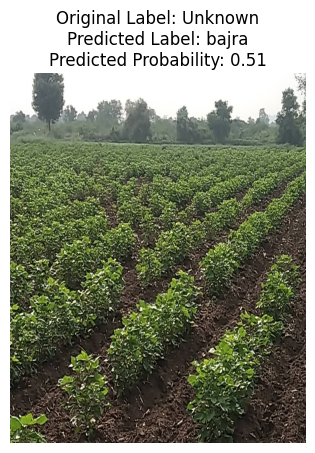

1/1 [==============================] - 0s 193ms/step
[[ 0.60886085 -0.21330804 -0.33107996]]


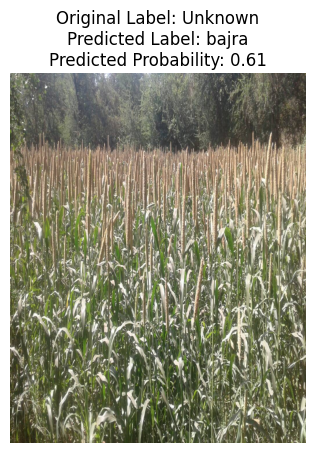

1/1 [==============================] - 0s 85ms/step
[[ 0.55442905 -0.16822062 -0.27484444]]


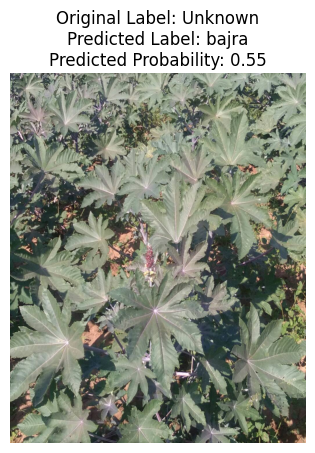

In [109]:

# class_names = {'bajra': 0, 'castor': 1, 'cotton': 2, 'paddy': 3, 'sugarcane': 4, 'wheat': 5}

class_names = {'bajra': 0, 'castor': 1, 'cotton': 2}

class_names_index = {0: 'bajra', 1: 'castor', 2: 'cotton'}

test_images_dir = r'/content/drive/MyDrive/test1'
image_file_names = os.listdir(test_images_dir)

## picking up images and make prediction
num_images_to_show = 9
selected_images = np.random.choice(image_file_names, num_images_to_show, replace=False)

for image_file in selected_images:
    image_path = os.path.join(test_images_dir, image_file)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (160,160))
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    predictions = model.predict(img)
    print(predictions)
    predicted_label = class_names_index[np.argmax(predictions)]
    predicted_probability = predictions.max()

 ## Plotting
    plt.figure()
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f'Original Label: Unknown\nPredicted Label: {predicted_label}\nPredicted Probability: {predicted_probability:.2f}')
    plt.axis('off')
    plt.show()


In [110]:
model_path = '/content/drive/MyDrive/models/baj_cas_cot_tf_doc_transfer_learning.h5'

model.save(model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [111]:
model = load_model('/content/drive/MyDrive/models/baj_cas_cot_tf_doc_transfer_learning.h5')
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_5 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_6 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_6 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           